# Determination of the best neural network for VBS analysis

In questo notebook proponiamo la ricerca della miglior configurazione di una rete neurale nel caso della componente z del quadrimomento in processi di scattering tra bosoni vettore semileptonici.

##	Ricordiamo che il dataset è suddiviso nel seguente modo:
	lepton flavour (1 electron, 0 muon) | E_l | px_l | py_l | pz_l | MET | MET_phi saved in 'ewk_signal_withreco_withdelta_input.py'
	massW | E_nu | px_nu| py_nu | pz_nu saved in 'ewk_signal_withreco_withdelta_truth.py'

## Importazione e versioni delle librerie usate.

In [2]:
import numpy
print('numpy:', numpy.__version__)

import scipy
print('scipy:', scipy.__version__)

import matplotlib
print('matplotlib:', matplotlib.__version__)

import IPython
print('iPython:', IPython.__version__)

import sklearn
print('scikit-learn:', sklearn.__version__)

import tensorflow
print('tensorflow:', tensorflow.__version__)

import keras
print('keras:', keras.__version__) #qui dovrebbe dare una riga rossa con "tensorflow as backend"

numpy: 1.15.4
scipy: 1.1.0
matplotlib: 3.0.1
iPython: 7.2.0
scikit-learn: 0.20.1
tensorflow: 1.12.0
keras: 2.2.4


Using TensorFlow backend.


In [17]:
import pylab as pl
import numpy as np  
import argparse
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import scipy.odr as odr 
from keras.activations import relu
from keras.activations import tanh
import matplotlib.pyplot as plt 
import matplotlib as mp
import itertools
import random
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout
from array import array
from sklearn import metrics
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn import svm, datasets
from scipy import interp
import models as M
from keras.callbacks import History 
history = History()
from models import *
from keras.callbacks import *
from sklearn.externals import joblib
from scipy.stats import norm
import scipy.stats

## Importazione del dataset sottoforma di numpy array

In [9]:
ewk_input = np.load('ewk_signal_withreco_withdelta_input.npy')
ewk_truth = np.load('ewk_signal_withreco_withdelta_truth.npy')


Dividiamo il dataset in training set, validation set e test set, vediamo inotlre se i dati sono stati importati in maniera corretta.

In [12]:
#	Import of 400000 entries of the nparray 

# 100000 entries for train

ewk_input_train = ewk_input[0:400000,:]
ewk_truth_train = ewk_truth[0:400000,4].reshape(-1, 1)


# 100000 entries for validation

ewk_input_validation = ewk_input[400000:450000,:]
ewk_truth_validation = ewk_truth[400000:450000,4].reshape(-1, 1)

#Stampo la prima riga e le dimensioni dei numpyarray in modo da vedere se sono stati importati nella maniera corretta
print(ewk_input[0,:])
print(ewk_input.shape)
print(ewk_truth.shape)


# 100000 entries for test
ewk_input_test = ewk_input[450000:501328,:]
ewk_truth_test = ewk_truth[450000:501328,4].reshape(-1, 1)



[  0.          57.0622945  -54.51616779  16.01704417   5.24854253
 102.68898411   3.92143733]
(501328, 7)
(501328, 10)
[ 0.          0.23106666 -0.56414794 -0.98000085  0.91218928 -0.36788357
  1.2257837 ]


Z-scaliamo il dataset in modo da ottenere dati più maneggiabili poichè sono più vicini allo 0.
Z-scalare vuol dire fare la seguente cosa:
$ data_{new} = \frac{data_{old}-\mu}{\sigma} $
Salviamo successivamente il modello scalato in un file 'scaler_input.pkl' in modo da poterlo richiamare successivamente

In [13]:
#	z-scale of the dataset:


#	Definition of the scaler
scaler_input = StandardScaler()
scaler_truth = StandardScaler()


scaler_input.fit(ewk_input_train)
scaler_truth.fit(ewk_truth_train)

input_train = scaler_input.transform(ewk_input_train)
truth_train = scaler_truth.transform(ewk_truth_train)
input_validation = scaler_input.transform(ewk_input_validation)
truth_validation = scaler_truth.transform(ewk_truth_validation)
input_test = scaler_input.transform(ewk_input_test)
truth_test = ewk_truth_test

print(input_test[0,:])


[ 0.          0.23106666 -0.56414794 -0.98000085  0.91218928 -0.36788357
  1.2257837 ]


In [16]:
#	Saving the scaler models
joblib.dump(scaler_input,  "scaler_input.pkl")
joblib.dump(scaler_truth,  "scaler_truth.pkl")


['scaler_truth.pkl']

## Importiamo ora il modello da provare nella nostra rete neurale:

Definiamo il decay_rate, il learning_rate e il numero di epochs e la patience, definiamo inoltre la directory in cui salvare i dati in modo da non doverla cambiare ogni volta:

In [53]:
decay_rate = 0
learning_rate = 1e-4
epoch = 100
patience = "0.001:50"
initial_epochs = 1
batch_size = 500
output_dir = "/risultati_predizioni/400_neuroni_4_stratinascosti"


Definiamo la rete neurale:

In [28]:
model = Sequential()

model.add(Dense(units=400,input_dim=input_validation.shape[1], activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=400,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=400,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=400,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=400,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1))
        
model.compile(loss=losses.mean_squared_error,
              optimizer='adam',
              metrics=[metrics.mean_absolute_error])



Completo la procedura di training.

In [37]:
auto_save = ModelCheckpoint("current_model", monitor='val_loss',
                    verbose=1, save_best_only=True, save_weights_only=False,
                    mode='auto', period=2)

min_delta = float(patience.split(":")[0])
p_epochs = int(patience.split(":")[1])
early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta,
                               patience=p_epochs, verbose=1)

def reduceLR (epoch):
    return learning_rate * (1 / (1 + epoch*decay_rate))

lr_sched = LearningRateScheduler(reduceLR, verbose=1)
csv_logger = CSVLogger('training.log')


print(">>> Training...")
W_val = np.ones(input_validation.shape[0])
history = model.fit(input_train, truth_train,
                        validation_data = (input_validation, truth_validation),
                        epochs=epoch, initial_epoch=initial_epochs,
                        batch_size=batch_size, shuffle=True,
                        callbacks=[auto_save, early_stop, lr_sched, csv_logger])

>>> Training...
Train on 400000 samples, validate on 50000 samples
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 48s 121us/step - loss: 0.4832 - mean_absolute_error: 0.4311 - val_loss: 0.3846 - val_mean_absolute_error: 0.3967
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 48s 121us/step - loss: 0.4127 - mean_absolute_error: 0.4105 - val_loss: 0.3799 - val_mean_absolute_error: 0.3944

Epoch 00003: val_loss improved from inf to 0.37988, saving model to current_model
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 48s 121us/step - loss: 0.4004 - mean_absolute_error: 0.4075 - val_loss: 0.3742 - val_mean_absolute_error: 0.3925
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [=========================


Epoch 00031: val_loss did not improve from 0.36382
Epoch 32/100

Epoch 00032: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 73s 181us/step - loss: 0.3756 - mean_absolute_error: 0.4004 - val_loss: 0.3709 - val_mean_absolute_error: 0.3890
Epoch 33/100

Epoch 00033: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 67s 169us/step - loss: 0.3757 - mean_absolute_error: 0.4005 - val_loss: 0.3646 - val_mean_absolute_error: 0.3947

Epoch 00033: val_loss did not improve from 0.36382
Epoch 34/100

Epoch 00034: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 64s 161us/step - loss: 0.3750 - mean_absolute_error: 0.4001 - val_loss: 0.3718 - val_mean_absolute_error: 0.3892
Epoch 35/100

Epoch 00035: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 66s 166us/step - loss: 0.3752 - m

400000/400000 [==============================] - 46s 116us/step - loss: 0.3723 - mean_absolute_error: 0.3992 - val_loss: 0.3682 - val_mean_absolute_error: 0.3908
Epoch 63/100

Epoch 00063: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 46s 116us/step - loss: 0.3720 - mean_absolute_error: 0.3993 - val_loss: 0.3638 - val_mean_absolute_error: 0.3917

Epoch 00063: val_loss improved from 0.36382 to 0.36379, saving model to current_model
Epoch 64/100

Epoch 00064: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 47s 118us/step - loss: 0.3730 - mean_absolute_error: 0.3996 - val_loss: 0.3688 - val_mean_absolute_error: 0.3903
Epoch 65/100

Epoch 00065: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 47s 117us/step - loss: 0.3720 - mean_absolute_error: 0.3994 - val_loss: 0.3668 - val_mean_absolute_error: 0.3911

Epoch 00065: val_l

400000/400000 [==============================] - 46s 114us/step - loss: 0.3701 - mean_absolute_error: 0.3985 - val_loss: 0.3683 - val_mean_absolute_error: 0.3908
Epoch 93/100

Epoch 00093: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 46s 115us/step - loss: 0.3695 - mean_absolute_error: 0.3985 - val_loss: 0.3802 - val_mean_absolute_error: 0.3887

Epoch 00093: val_loss did not improve from 0.36179
Epoch 94/100

Epoch 00094: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 46s 116us/step - loss: 0.3700 - mean_absolute_error: 0.3985 - val_loss: 0.3844 - val_mean_absolute_error: 0.3902
Epoch 95/100

Epoch 00095: LearningRateScheduler setting learning rate to 0.0001.
400000/400000 [==============================] - 47s 117us/step - loss: 0.3703 - mean_absolute_error: 0.3986 - val_loss: 0.3653 - val_mean_absolute_error: 0.3919

Epoch 00095: val_loss did not improve from 0.36179
Ep

Passiamo ora alla fase di test, facciamo agire la nostra rete neurale con i pesi trovati in precedenza per fare predizioni sul nostro dataset, Z-scaliamo inoltre i dati al contrario per avere i valori reali e non vicini allo 0.

In [39]:
predictions = model.predict(input_test,batch_size=2048)
predictions = np.concatenate(predictions)
predictions = scaler_truth.inverse_transform(predictions)

Facciamo ora qualche plot utile per visualizzare i dati, nel primo caso si tratta di uno scatter plot in cui i dati predetti vengono comparati con quelli reali, nel secondo caso è sempre uno scatter plot 2D in cui al posto dei pallini usiamo i colori per diversificare il numero di conteggi:

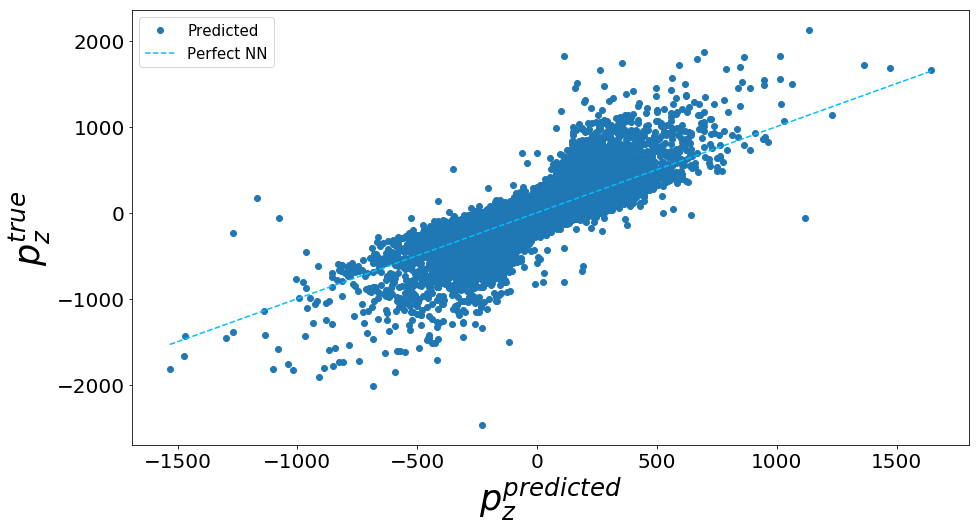

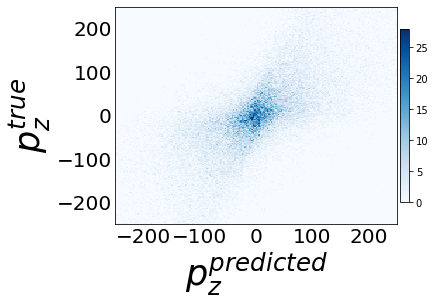

In [41]:
def scatter_plotter(pred, y):
    #Plotting
    fig = plt.figure(figsize=(15,8))
    plt.plot(pred,y, 'o', label = "Predicted")
    top = max(pred)
    bottom = min(pred)
    
    #Disegna la bisettrice, ossia la retta su cui dovrebbero stare i dati nel caso in cui fossero predetti alla perfezione
    plt.plot([bottom,top],[bottom,top], "r--", color = "deepskyblue", label = "Perfect NN")
    plt.xticks( fontsize = 20)
    plt.yticks( fontsize = 20)
    plt.xlabel(r'$p_{z}^{predicted}$', size = 35) 
    plt.ylabel(r'$p_{z}^{true}$', size = 35) 
    plt.legend(loc="best", prop={'size': 15})
    plt.show()
    plt.ioff()
    #fig.savefig(output_dir+'/scatter_plot.png', bbox_inches='tight')
    
def plot_2d_hist_1(y, pred):  
    

    fig = plt.figure()
    ax = fig.add_subplot(111)

    H = ax.hist2d(y, pred, bins=200, range = [[-250,250],[-250,250]] , cmap = "Blues")

    fig.colorbar(H[3], ax=ax, shrink=0.8, pad=0.01, orientation="vertical")
    ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.xticks( fontsize = 20)
    plt.yticks( fontsize = 20)
    plt.xlabel(r'$p_{z}^{predicted}$', size = 35) 
    plt.ylabel(r'$p_{z}^{true}$', size = 35) 
    plt.show()
    #fig.savefig(output_dir+'/predictions_histogram2d_plot.pdf', bbox_inches='tight')

    
scatter_plotter(predictions, np.concatenate(truth_test))
plot_2d_hist_1(predictions, np.concatenate(truth_test))

Salviamo ora i dati in un file esterno in modo da poterli richiamare successivamente per fare dei confronti:

In [51]:
np.savetxt(output_dir + "/predictions.txt" , predictions)

print(">>>>>>>>> SAVING HYPERPARAMETERS >>>>>>>>")
f = open(output_dir + "/configs.txt", "w")
f.write("epochs: {0}\n".format(epoch))
f.write("batch_size: {0}\n".format(batch_size))
f.write("learning_rate: {0}\n".format(learning_rate))
f.write("decay_rate: {0}\n".format(decay_rate))
f.write("patience: {0}\n".format(patience))
f.close()


FileNotFoundError: [Errno 2] No such file or directory: '/risultati_predizioni/400_neuroni_4_stratinascosti/predictions.txt'

# Calcolo della rete migliore:
Passiamo ora al calcolo della rete migliore, in particolare, dopo aver provato diverse configurazioni confrontiamo le loss function e le predizioni.